<font  size="5" color="green"><strong>Maratona Behind The Code 2021</strong></font>

<a name="index"></a>

## Desafio 05 | SONDA

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**Desafio 05 | SONDA: [GitHub](https://github.com/maratonadev/desafio-5-2021/blob/main/doc/instructions/pt.md#desafio-05--sonda)**

## Introdução

Esse artigo foi desenvolvido para mostrar a aplicação do fluxo de trabalho de __Machine Learning__ em um projeto do mundo real.

## O Desafio

Esse projeto foi baseado no Desafio 05 | SONDA da Maratona Behind The Code 2021. 

__Desafio de negócio__

"O desafio consiste em um problema comum na área de Ciência de Dados. Um cliente expõe um problema específico de sua área e através da sua análise encontrar uma possível solução. Um cliente da área Telecomunicações reportou problema de perda de clientes (__Churn__) e gostaria de conseguir identificar essa possível perda antes que ela ocorra, por meio de inteligência artificial."

__Objetivo__

“O desafio consiste de implementar um algoritmo de Machine Learning para __classificação binária__, capaz de identificar se um cliente será perdido ou não.”

## Churn

São conhecidos como __Churn__ os problemas da área de negócios que tratam da saída de clientes da base de negócio. Gerando preocupação nos negócios de elevada aquisição de clientes, impactando nas vendas e podendo desequilibra o fluxo de caixa da empresa, etc.

## Import Packages

Fazendo a importação dos principais pacotes do python

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Set parameters

Configuração dos principais paramentos para utilização do python, e sklearn (threads, CPU, RAM, seeds...). 

In [3]:
N_THREADS = 16 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
N_SPLITS = 5 # splits KFolds
N_TRIAL = 30 # number os trial of val score, optuna
N_JOBS = -1 # -1 means using all processors
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
EPOCHS = 50
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 16 #  Number of RAM limit
CPU_LIMIT = 8 # Number of CPU limit
TARGET_NAME = 'CHURN'

## Create directories for project

Vamos criar dois diretórios, o diretório __“db/”__ para salvar os arquivos da biblioteca “Optuna” e o diretório __“models/”__ para salvar nosso modelo final.

In [6]:
import os

Path = ""

# define the name of the directory to be created
path_db = "db/"
path_mdl = "models/"

paths = []
paths.append(path_db)
paths.append(path_mdl)

try:
    for path in paths:
        os.mkdir(Path+path)
except OSError:
    for path in paths:
        print (f"Creation of the directory failed: {path} ")
else:
    for path in paths:
        print (f"Successfully created the directory: {path}")

Successfully created the directory: db/
Successfully created the directory: models/


## Load Datasets

Ler os bancos de dados de treinamento, validação e teste. No nosso caso são arquivos CSV.

In [4]:
Path = ""

data = pd.read_csv(Path+"data/dataset.csv")
print(data.shape)
data.head()

(4548, 21)


,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,...,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,3418,Female,0.0,No,No,26.0,Yes,No,DSL,No,...,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),131.55,1483.7,No
1,6865,Male,0.0,No,No,39.0,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),79.61,2737.31,No
2,2799,Male,0.0,No,No,1.0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),9.26,9.26,No
3,1584,Male,0.0,Yes,Yes,66.0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),42.14,1689.19,No
4,9997,Male,0.0,No,No,56.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Electronic check,126.24,5608.69,No


# Exploratory Data Analysis (EDA)

Vamos começar com uma análise inicial, onde poderemos verificar a estrutura dos dados, se existem dados faltantes, se existem valores duplicados, visualizar graficamente as variáveis e etc.

| Coluna           | Descrição                                                                                        |
| ---------------- | ------------------------------------------------------------------------------------------------ |
| ID               | Customer ID                                                                                      |
| GENDER           | Whether the customer is a male or a female                                                       |
| SENIORCITIZEN    | Whether the customer is a senior citizen or not (1, 0)                                           |
| PARTNER          | Whether the customer has a partner or not (Yes, No)                                              |
| DEPENDENTS       | Whether the customer has dependents or not (Yes, No)                                             |
| TENURE           | Number of months the customer has stayed with the company                                        |
| PHONESERVICE     | Whether the customer has a phone service or not (Yes, No)                                        |
| MULTIPLELINES    | Whether the customer has multiple lines or not (Yes, No, No phone service)                       |
| INTERNETSERVICE  | Customer’s internet service provider (DSL, Fiber optic, No)                                      |
| ONLINESECURITY   | Whether the customer has online security or not (Yes, No, No internet service)                   |
| ONLINEBACKUP     | Whether the customer has online backup or not (Yes, No, No internet service)                     |
| DEVICEPROTECTION | Whether the customer has device protection or not (Yes, No, No internet service)                 |
| TECHSUPPORT      | Whether the customer has tech support or not (Yes, No, No internet service)                      |
| STREAMINGTV      | Whether the customer has streaming TV or not (Yes, No, No internet service)                      |
| STREAMINGMOVIES  | Whether the customer has streaming movies or not (Yes, No, No internet service)                  |
| CONTRACT         | The contract term of the customer (Month-to-month, One year, Two year)                           |
| PAPERLESSBILLING | Whether the customer has paperless billing or not (Yes, No)                                      |
| PAYMENTMETHOD    | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MONTHLYCHARGES   | The amount charged to the customer monthly                                                       |
| TOTALCHARGES     | The total amount charged to the customer                                                         |
| CHURN            | Whether the customer churned or not (Yes or No)                                                  |

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                4548 non-null   int64  
 1   GENDER            4520 non-null   object 
 2   SENIORCITIZEN     4523 non-null   float64
 3   PARTNER           4524 non-null   object 
 4   DEPENDENTS        4526 non-null   object 
 5   TENURE            4533 non-null   float64
 6   PHONESERVICE      4520 non-null   object 
 7   MULTIPLELINES     4523 non-null   object 
 8   INTERNETSERVICE   4524 non-null   object 
 9   ONLINESECURITY    4518 non-null   object 
 10  ONLINEBACKUP      4518 non-null   object 
 11  DEVICEPROTECTION  4524 non-null   object 
 12  TECHSUPPORT       4530 non-null   object 
 13  STREAMINGTV       4523 non-null   object 
 14  STREAMINGMOVIES   4523 non-null   object 
 15  CONTRACT          4525 non-null   object 
 16  PAPERLESSBILLING  4517 non-null   object 


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1324 non-null   int64  
 1   GENDER            1324 non-null   object 
 2   SENIORCITIZEN     1324 non-null   int64  
 3   PARTNER           1324 non-null   object 
 4   DEPENDENTS        1324 non-null   object 
 5   TENURE            1324 non-null   int64  
 6   PHONESERVICE      1324 non-null   object 
 7   MULTIPLELINES     1324 non-null   object 
 8   INTERNETSERVICE   1324 non-null   object 
 9   ONLINESECURITY    1324 non-null   object 
 10  ONLINEBACKUP      1324 non-null   object 
 11  DEVICEPROTECTION  1324 non-null   object 
 12  TECHSUPPORT       1324 non-null   object 
 13  STREAMINGTV       1324 non-null   object 
 14  STREAMINGMOVIES   1324 non-null   object 
 15  CONTRACT          1324 non-null   object 
 16  PAPERLESSBILLING  1324 non-null   object 


## Describe Columns

Aqui verificaremos o tipo de cada uma das variáveis nos bancos de traino e validação.
- Se as variáveis forem categóricas, veremos a quantidade de valores únicos, qual valor mais se repete e com qual frequência.

- Se as variáveis forem numéricas, veremos várias descrições estatísticas: media, desvio padrão, valores máximos e mínimos, quartis.

In [6]:
# Select numeric columns
cols_list = [col for col in data.columns if col not in [TARGET_NAME, 'ID']]

def describe_cols(df):

    for col in cols_list:
        print(f"-----DESCRIBE-----")
        print(f"\t Column: {col}")
        print(f"\t Type: {df[col].dtype} \n")
        print(f"\t Is null value: {df[col].describe()} \n\n")

describe_cols(data)

-----DESCRIBE-----
	 Column: GENDER
	 Type: object 

	 Is null value: count     4520
unique       2
top       Male
freq      2271
Name: GENDER, dtype: object 


-----DESCRIBE-----
	 Column: SENIORCITIZEN
	 Type: float64 

	 Is null value: count    4523.000000
mean        0.163608
std         0.369961
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SENIORCITIZEN, dtype: float64 


-----DESCRIBE-----
	 Column: PARTNER
	 Type: object 

	 Is null value: count     4524
unique       2
top         No
freq      2319
Name: PARTNER, dtype: object 


-----DESCRIBE-----
	 Column: DEPENDENTS
	 Type: object 

	 Is null value: count     4526
unique       2
top         No
freq      3183
Name: DEPENDENTS, dtype: object 


-----DESCRIBE-----
	 Column: TENURE
	 Type: float64 

	 Is null value: count    4533.000000
mean       31.812927
std        24.419055
min         0.000000
25%         8.000000
50%        28.000000
75%        54.000000
max 

In [8]:
describe_cols(test)

-----DESCRIBE-----
	 Column: GENDER
	 Type: object 

	 Is null value: count     1324
unique       2
top       Male
freq       671
Name: GENDER, dtype: object 


-----DESCRIBE-----
	 Column: SENIORCITIZEN
	 Type: int64 

	 Is null value: count    1324.000000
mean        0.157100
std         0.364032
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SENIORCITIZEN, dtype: float64 


-----DESCRIBE-----
	 Column: PARTNER
	 Type: object 

	 Is null value: count     1324
unique       2
top         No
freq       689
Name: PARTNER, dtype: object 


-----DESCRIBE-----
	 Column: DEPENDENTS
	 Type: object 

	 Is null value: count     1324
unique       2
top         No
freq       936
Name: DEPENDENTS, dtype: object 


-----DESCRIBE-----
	 Column: TENURE
	 Type: int64 

	 Is null value: count    1324.000000
mean       33.714502
std        25.065660
min         0.000000
25%        10.000000
50%        30.000000
75%        58.000000
max     

## Null values

Identificar se existe e a quantidade de valores faltantes nos bancos de traino e validação.

In [9]:
data.isnull().sum()

ID                   0
GENDER              28
SENIORCITIZEN       25
PARTNER             24
DEPENDENTS          22
TENURE              15
PHONESERVICE        28
MULTIPLELINES       25
INTERNETSERVICE     24
ONLINESECURITY      30
ONLINEBACKUP        30
DEVICEPROTECTION    24
TECHSUPPORT         18
STREAMINGTV         25
STREAMINGMOVIES     25
CONTRACT            23
PAPERLESSBILLING    31
PAYMENTMETHOD       28
MONTHLYCHARGES      21
TOTALCHARGES        21
CHURN                0
dtype: int64

In [10]:
test.isnull().sum()

ID                  0
GENDER              0
SENIORCITIZEN       0
PARTNER             0
DEPENDENTS          0
TENURE              0
PHONESERVICE        0
MULTIPLELINES       0
INTERNETSERVICE     0
ONLINESECURITY      0
ONLINEBACKUP        0
DEVICEPROTECTION    0
TECHSUPPORT         0
STREAMINGTV         0
STREAMINGMOVIES     0
CONTRACT            0
PAPERLESSBILLING    0
PAYMENTMETHOD       0
MONTHLYCHARGES      0
TOTALCHARGES        0
CHURN               0
dtype: int64

## Duplicate

Identifica se existem valores duplicados entres as observações(linhas do banco de dados) nos bancos de traino e validação.

In [11]:
print(data.duplicated().sum())
print(test.duplicated().sum())

0
0


## Plots

Visualizar estrutura dos dados numéricos.

3


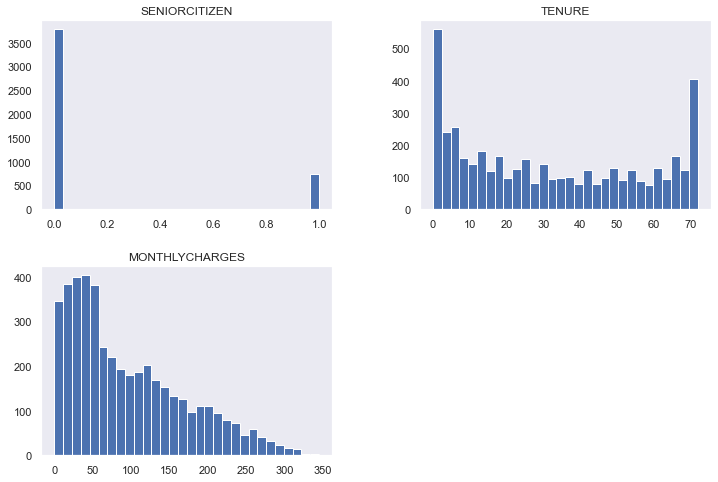

In [6]:
cols_num = [col for col in data.select_dtypes(include="number").columns if col not in ['ID', TARGET_NAME]]
print(len(cols_num))

data[cols_num].hist(grid=False,
                    figsize=(12, 8),
                    bins=30);

### Visualizar os dados Categóricos.

- A variável 'TOTALCHARGES' foi excluída dos gráficos devido a quantidade de valores únicos (4495 valores únicos), isso gera um erro no gráfico por causa da grande quantidade de valores.

In [7]:
cols_obj = [col for col in data.select_dtypes(include="object").columns if col not in ['ID', 
                                                                                       TARGET_NAME, 'TOTALCHARGES']]
print(len(cols_obj))

def bar_chart(data, feature):
    posit = data[data[TARGET_NAME] == 'Yes'][feature].value_counts()
    neg = data[data[TARGET_NAME] == 'No'][feature].value_counts()      
    df = pd.DataFrame([posit, neg], index=['Yes', 'No'])    
    df.plot(kind='bar', stacked = True, figsize = (10, 5))  
    plt.title(feature);

15


Wall time: 400 ms


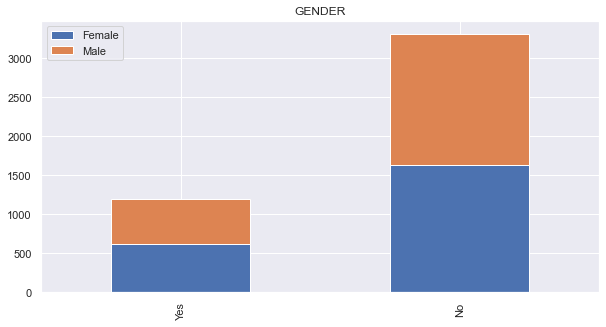

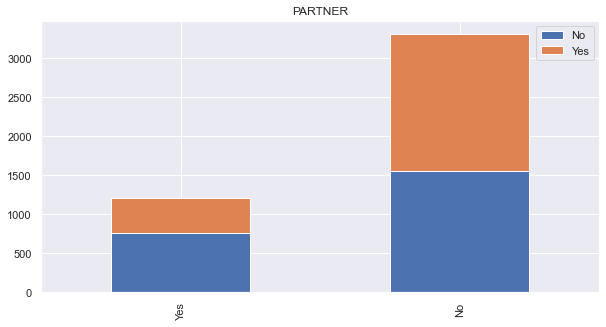

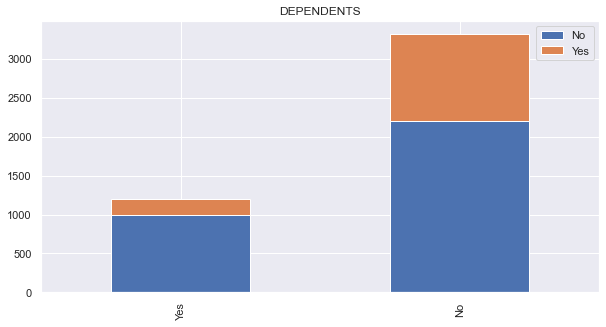

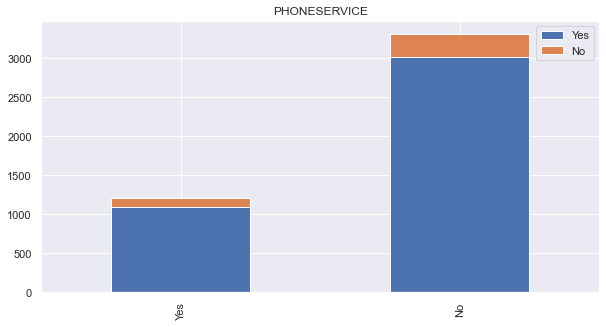

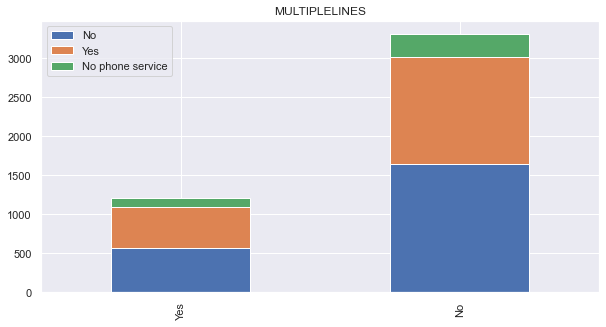

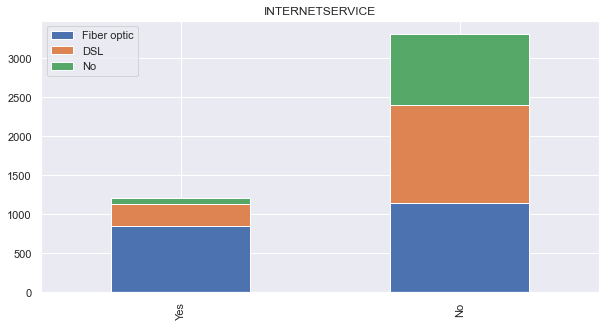

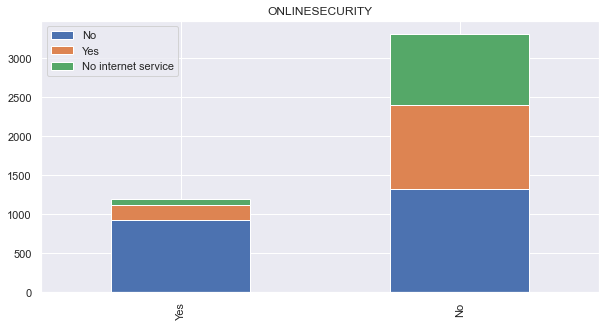

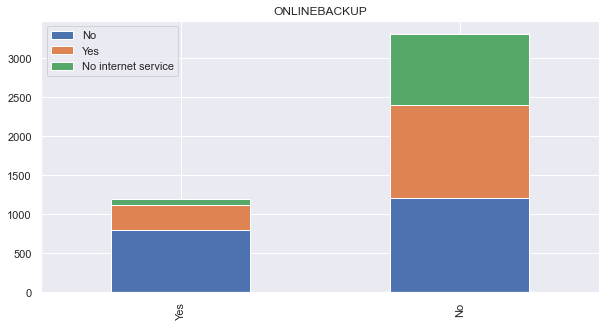

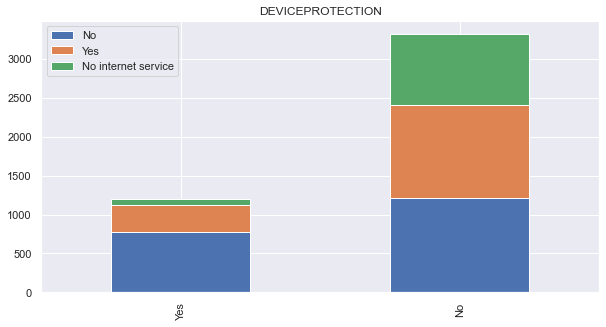

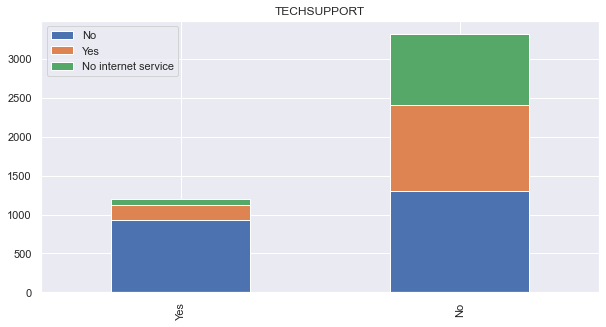

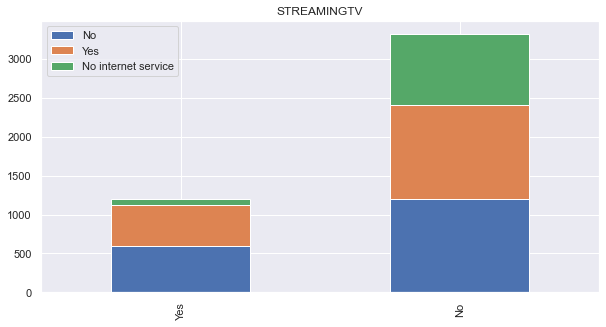

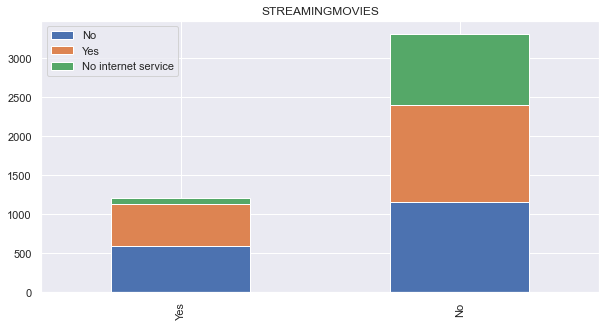

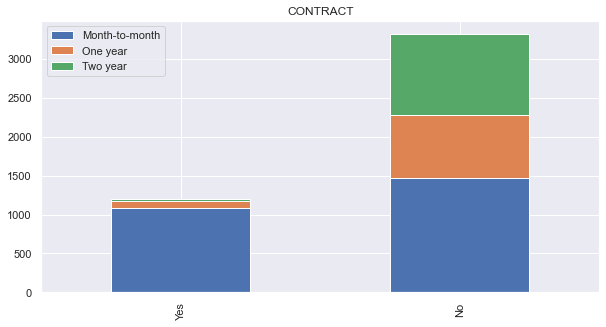

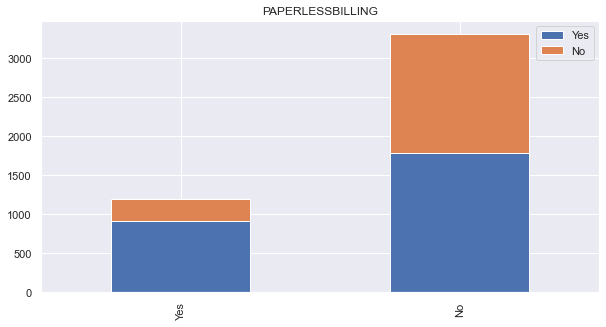

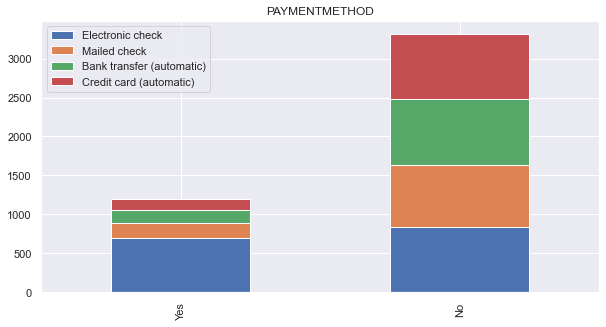

In [8]:
%%time

for col in cols_obj:
    bar_chart(data, col)

Avaliando desbalanceamento variável alvo "CHURN" (existe muito mais valores “No” do que “Yes” na coluna CHURN).

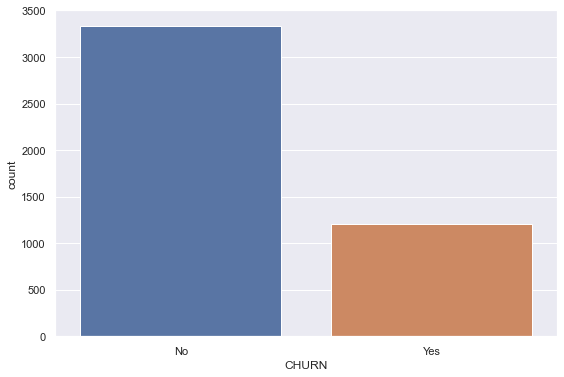

In [9]:
fig = plt.subplots(figsize=(9, 6))

sns.countplot(x=TARGET_NAME, data=data);

# Data Prepocessing and Data Engineering

Foram realizados alguns testes com as __features (variáveis)__, __transformação de features__ e modelos de __Machine Learining__. Não mostraremos todos os testes feitos. Os pre-processamentos e algoritmos testados, são: 

- __Features__: Usaremos todas as colunas, ou excluindo a coluna “ID”;
- __Tipo de conversão de texto em números__: Label Econdec e Target Econdec;
- __Algoritmos de classificação binária__: LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, LGBMClassifier e CatBoostClassifier.

__Melhor combinação:__ colunas excluindo a coluna “ID”,  Label Econdec com algoritmos CatBoostClassifier.

In [5]:
train = data.copy()

train.shape

(4548, 21)

Removendo a coluna "ID".

In [6]:
train.drop('ID', axis=1, inplace=True)

train.shape

(4548, 20)

## Treated null values

Aqui trataremos os valores faltantes (NaN). Como a coluna com a maior quantidade de NaN tem __31 Nan__ em um universo de __4548 observações__. 
Vamos substituir os valores de cada coluna por valores que mais se repetem ou um valor diferente do que tem na coluna.   
No caso das colunas com valores numéricos preencheremos o NaN com a media.

In [7]:
train['GENDER'].fillna('Male', inplace=True)
train['SENIORCITIZEN'].fillna(0.0, inplace=True)
train['PARTNER'].fillna('No', inplace=True)
train['DEPENDENTS'].fillna('No', inplace=True)
train['TENURE'].fillna(train['TENURE'].median(), inplace=True)
train['PHONESERVICE'].fillna('No', inplace=True)
train['MULTIPLELINES'].fillna('No phone service', inplace=True)
train['INTERNETSERVICE'].fillna('No', inplace=True)
train['ONLINESECURITY'].fillna('No internet service', inplace=True)
train['ONLINEBACKUP'].fillna('No internet service', inplace=True)
train['DEVICEPROTECTION'].fillna('No internet service', inplace=True)
train['TECHSUPPORT'].fillna('No internet service', inplace=True)
train['STREAMINGTV'].fillna('No internet service', inplace=True)
train['STREAMINGMOVIES'].fillna('No internet service', inplace=True)
train['TECHSUPPORT'].fillna('No internet service', inplace=True)
train['CONTRACT'].fillna('Other', inplace=True)
train['PAPERLESSBILLING'].fillna('No', inplace=True)
train['PAYMENTMETHOD'].fillna('Other', inplace=True)
train['MONTHLYCHARGES'].fillna(train['MONTHLYCHARGES'].mean(), inplace=True)
train['TOTALCHARGES'] = pd.to_numeric(train['TOTALCHARGES'], errors='coerce')
train['TOTALCHARGES'].fillna(train['TOTALCHARGES'].mean(), inplace=True)

## LabelEncoder

Realizando a transformação das variáveis texto em numéricas.

In [8]:
from sklearn.preprocessing import LabelEncoder

# Select object columns
cols_obj = [col for col in data.select_dtypes(include="object").columns if col not in [TARGET_NAME]]
print(len(cols_obj))
cols_obj

enc_label = LabelEncoder()

train[TARGET_NAME] = enc_label.fit_transform(train[TARGET_NAME])


# Label Encoding      
for col in cols_obj:      
    enc_label = LabelEncoder()
    
    train[col] = enc_label.fit_transform(train[col])
    


print(train.shape)
train.head()

16
(4548, 20)


,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,0,0.0,0,0,26.0,1,0,0,0,2,2,0,0,0,0,1,1,131.55,2321,0
1,1,0.0,0,0,39.0,1,2,1,0,0,0,0,0,0,0,1,1,79.61,3034,0
2,1,0.0,0,0,1.0,1,0,2,1,1,1,1,1,1,0,0,1,9.26,34,0
3,1,0.0,1,1,66.0,1,2,2,1,1,1,1,1,1,3,1,1,42.14,2470,0
4,1,0.0,0,0,56.0,1,2,1,0,2,0,0,2,2,0,0,2,126.24,3934,0


# Train Baseline Model

Nesta parte vamos treinar o nosso modelo __Baseline (o modelo base)__ de __classificação binária__. Para isso dividiremos o dataset que tem __4548 observações__, sendo 70% para treinamento e 30% para validação usando a métrica __“F1 Scores”__ que foi a métrica usado no desafio da __IBM__.

### F1 score

<font size="4">$$ F1 \; Score =  \frac {2 * Precision * Recall} {Precision + Recall} = \frac {2 TP} {2 TP + FP + FN}$$</font>

- Média harmônica entre **Precision** e **Recall**.
    - Minimiza os **FP - False Positives. → Precison**
    - Minimiza os **FN - False Negative. → Recall**

## Create X, y variables

- O “X” são as variáveis que o modelo vai utilizar para fazer as previsões (variáveis independentes).
- O “y” é a variável alvo, a variável que o modelo vai prever (variável dependente).

In [9]:
X = train.drop(TARGET_NAME, axis=1)
y = train[TARGET_NAME]

print(X.shape, y.shape)

(4548, 19) (4548,)


## Division of training and validation databases 

Dividindo a variável dependente (y) e independente (X) sendo 70% para treinamento e 30% para validação.

In [10]:
from sklearn.model_selection import train_test_split

# split the data with 30% in validation set
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y, 
                                                      stratify = y,
                                                      test_size=TEST_SIZE, 
                                                      random_state=SEED) 

print(f"Train 70%, Valid 30% data: {X_train.shape, X_valid.shape}",\
                                    y_train.shape, y_valid.shape)

Train 70%, Valid 30% data: ((3183, 19), (1365, 19)) (3183,) (1365,)


## CatBoostClassifier

Treinando o modelo __CatBoostClassifier__ para classificação binária e verificando a métrica __“F1 Score”__.

In [14]:
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier


from timeit import default_timer as timer
from datetime import timedelta, datetime


# Start Measure time elapsed
start = timer()
print(f"Time Started: {datetime.now().strftime('%H:%M:%S')}\n")
# Code here ...


mdl = CatBoostClassifier(random_state=SEED,                          
                         verbose=0)

mdl.fit(X_train, y_train)

preds = mdl.predict(X_valid)

print(f"F1 Scores: {f1_score(y_valid, preds):0.6f}")


# End Measure time elapsed
end = timer()
print(f'\nTime Elapsed: {timedelta(seconds = end - start)}')

Time Started: 14:06:33

F1 Scores: 0.561129

Time Elapsed: 0:00:02.689437


# Improving Machine Learning Model

Aqui vamos tentar melhorar nosso modelo __ML (Machine Learning)__ com algumas técnicas:

- Hyperparameter Tuning;
- Feature Importance;
- Imbalance Data.

## Hyperparameter Tuning: with Optuna

Vamos utilizar a biblioteca __“Optuna”__ para fazer o melhorar os hiperparâmetros do modelo.   
Uma das vantagens dessa biblioteca é a possibilidade de salvar os resultados (na pasta “db/”) em um arquivo sql, isso possibilita interromper tune e posteriormente retornamos sem perder todo o trabalho anterior.

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier

import optuna

def objective(trial):
    
    kf = KFold(n_splits=N_FOLDS, 
                shuffle=True, 
                random_state=SEED)
    
    
    params = {
        "n_estimators" : trial.suggest_categorical('n_estimators', [0, 2, 5, 10, 50, 100, 300, 500, 800, 1000, 1200, 1500, None]),        
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2, 1e-1, None]), 
        'max_depth': trial.suggest_categorical('max_depth', [0, 2, 5, 10, 50, 80, 100, 300, 500, None]),         
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [0, 2, 5, 10, 30, 50, 80, 100, None])        
    } 
    
    mdl = CatBoostClassifier(**params,
                             random_state=SEED, 
                             verbose=0)
        
    cross_val = cross_val_score(mdl, 
                            X, 
                            y, 
                            cv = kf, 
                            n_jobs=N_JOBS,
                            scoring = 'f1', 
                            verbose = VERBOSE).mean()
    

    return cross_val



from timeit import default_timer as timer
from datetime import timedelta, datetime

# Start Measure time elapsed
start = timer()
print(f"Time Started: {datetime.now().strftime('%H:%M:%S')}")
# Code here ...

db_path = "db/"


# study = optuna.create_study(direction='maximize')

study = optuna.create_study(direction='maximize',
                            study_name = "catb_parans",
                            storage = f"sqlite:///{db_path}catb_parans.db",
                            load_if_exists = True)

study.optimize(objective, 
               n_trials = N_TRIAL, 
               timeout = None,
               n_jobs=N_JOBS)


# End Measure time elapsed
end = timer()
print(f'\nTime Elapsed: {timedelta(seconds = end - start)}')


print(f"\nBest score: {study.best_trial.value:0.6f}" )
print("Best parameter:")
print(study.best_trial.params)

[I 2022-09-15 14:06:51,065] A new study created in RDB with name: catb_parans


Time Started: 14:06:50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished
[I 2022-09-15 14:07:06,814] Trial 13 finished with value: 0.5140572944029211 and parameters: {'n_estimators': 500, 'learning_rate': 0.0001, 'max_depth': None, 'l2_leaf_reg': 50}. Best is trial 4 with value: 0.5473160357203424.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished
[I 2022-09-15 14:07:07,330] Trial 12 finished with value: 0.582778406777624 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 5, 'l2_leaf_reg': None}. Best is trial 12 with value: 0.582778406777624.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
[I 2022-09-15 14:07:10,240] Trial 29 finished with value: 0.5216519904111145 and parameters: {'n_estimators': 1000, 'learning_rate': 0.001, 'max_depth': 5, 'l2_leaf_reg': 2}. Best is trial 12 with value: 0.582778406777624.



Time Elapsed: 0:00:19.354257

Best score: 0.582778
Best parameter:
{'l2_leaf_reg': None, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800}


## Feature Importance

Agora poderemos realizar o treinamento do modelo com os melhores parâmetros, em seguida utilizar atributo __“feature_importances_”__ do modelo, no caso __“CatBoostClassifier”__ para verificar quais as melhores features (colunas).

In [11]:
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier


from timeit import default_timer as timer
from datetime import timedelta, datetime


# Start Measure time elapsed
start = timer()
print(f"Time Started: {datetime.now().strftime('%H:%M:%S')}\n")
# Code here ...

# params = study.best_trial.params
params = {'l2_leaf_reg': None, 'learning_rate': 0.01, 
          'max_depth': 5, 'n_estimators': 800}

mdl = CatBoostClassifier(**params,
                         random_state=SEED,                          
                         verbose=0)

mdl.fit(X_train, y_train)

preds = mdl.predict(X_valid)

print(f"F1 Scores: {f1_score(y_valid, preds):0.6f}")


# End Measure time elapsed
end = timer()
print(f'\nTime Elapsed: {timedelta(seconds = end - start)}')

Time Started: 13:05:23

F1 Scores: 0.588050

Time Elapsed: 0:00:02.104413


Verificando as melhores features (colunas) para o nosso modelo.

In [12]:
mdl.feature_importances_

array([ 2.12237082,  1.682083  ,  0.52951425,  1.70855037, 13.77836393,
        0.5675707 ,  4.07316913, 10.85886265,  5.28864355,  2.59973294,
        2.96545961,  7.48053645,  3.6825782 ,  3.72166597, 18.206688  ,
        3.94967033,  5.20407917,  6.5522868 ,  5.02817412])

O gráfico com as 19 melhores features do modelo.

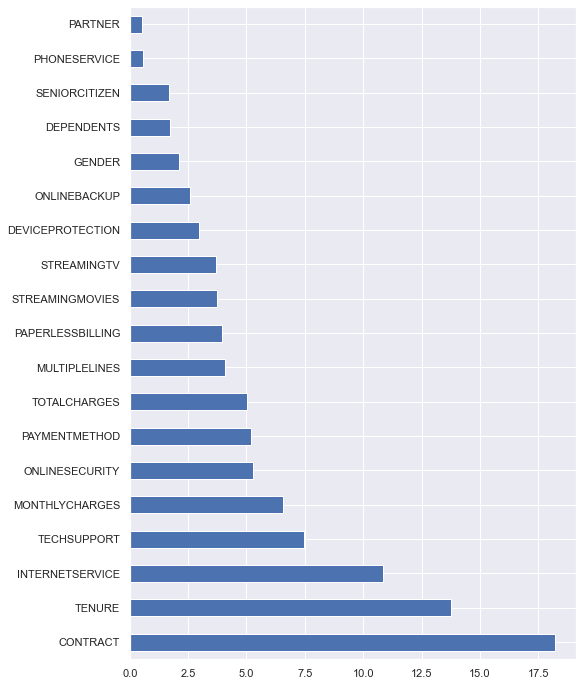

In [13]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(8, 12))
feat_importances = pd.Series(mdl.feature_importances_, index=X.columns)
feat_importances.nlargest(19).plot(kind='barh')
plt;

Vamos trainar o modelo com diferentes quantidades de features [3, 6, 8, 9, 12, 13, 14, 15, 16]. O melhor valor do “F1 Scores” foi para 15 melhores features do __Feature Importance__.

In [34]:
feats = []
num_cols = [3, 6, 8, 9, 12, 13, 14, 15, 16]

for n_feats in num_cols:
    feat = list(feat_importances.nlargest(n_feats).index)
#     print(len(feat))
    feats.append(feat)
                
# feats                

In [35]:
from timeit import default_timer as timer
from datetime import timedelta, datetime


# Start Measure time elapsed
start = timer()
print(f"Time Started: {datetime.now().strftime('%H:%M:%S')}\n")
# Code here ...

for idx, feat in tqdm(enumerate(feats)):
    mdl.fit(X_train[feat], y_train)

    preds = mdl.predict(X_valid[feat])

    print(f"Index: {idx} \t | Len of features: {len(feat)} \t | F1 Scores: {f1_score(y_valid, preds):0.6f}")
    

# End Measure time elapsed
end = timer()
print(f'\nTime Elapsed: {timedelta(seconds = end - start)}')

Time Started: 15:06:02



0it [00:00, ?it/s]

Index: 0 	 | Len features: 3 	 | F1 Scores: 0.563077
Index: 1 	 | Len features: 6 	 | F1 Scores: 0.542636
Index: 2 	 | Len features: 8 	 | F1 Scores: 0.567901
Index: 3 	 | Len features: 9 	 | F1 Scores: 0.566616
Index: 4 	 | Len features: 12 	 | F1 Scores: 0.601852
Index: 5 	 | Len features: 13 	 | F1 Scores: 0.602151
Index: 6 	 | Len features: 14 	 | F1 Scores: 0.595679
Index: 7 	 | Len features: 15 	 | F1 Scores: 0.607088
Index: 8 	 | Len features: 16 	 | F1 Scores: 0.584375

Time Elapsed: 0:00:15.892949


Selecionando as 15 melhores features do __Feature Importance__.

In [16]:
idx = 7

feat_import = feats[idx]
len(feats[idx]), feats[idx]

(15,
 ['CONTRACT',
  'TENURE',
  'INTERNETSERVICE',
  'TECHSUPPORT',
  'MONTHLYCHARGES',
  'ONLINESECURITY',
  'PAYMENTMETHOD',
  'TOTALCHARGES',
  'MULTIPLELINES',
  'PAPERLESSBILLING',
  'STREAMINGMOVIES',
  'STREAMINGTV',
  'DEVICEPROTECTION',
  'ONLINEBACKUP',
  'GENDER'])

Realizando o treinamento do modelo com as melhores features.

In [18]:
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier


from timeit import default_timer as timer
from datetime import timedelta, datetime


# Start Measure time elapsed
start = timer()
print(f"Time Started: {datetime.now().strftime('%H:%M:%S')}\n")
# Code here ...


# params = study.best_trial.params

mdl = CatBoostClassifier(**params,
                         random_state=SEED,                          
                         verbose=0)

mdl.fit(X_train[feat_import], y_train)

preds = mdl.predict(X_valid[feat_import])

print(f"F1 Scores: {f1_score(y_valid, preds):0.6f}")


# End Measure time elapsed
end = timer()
print(f'\nTime Elapsed: {timedelta(seconds = end - start)}')

Time Started: 13:07:10

F1 Scores: 0.607088

Time Elapsed: 0:00:01.768110


In [31]:
data[TARGET_NAME].value_counts()

No     3337
Yes    1211
Name: CHURN, dtype: int64

In [32]:
(3337 + 1211)

4548

## Imbalance Data

Como foi observado na parte dos gráficos a variável alvo a coluna “CHURN ”, está com os dados desbalanceados. Existe muito mais valores do tipo “No” do que variáveis do tipo “Yes”. 

Vamos utilizar a técnica de Oversampling com a biblioteca “SMOTE” para tratar o desbalanceamento dos dados.  
__Oversampling (sobreamostragem)__ aumentar artificialmente as observações da classe minoritária.

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print(f"Oversampling: X_train_over = {X_train_over.shape}, y_train_over = {y_train_over.shape}\n")

Oversampling: X_train_over = (4670, 19), y_train_over = (4670,)



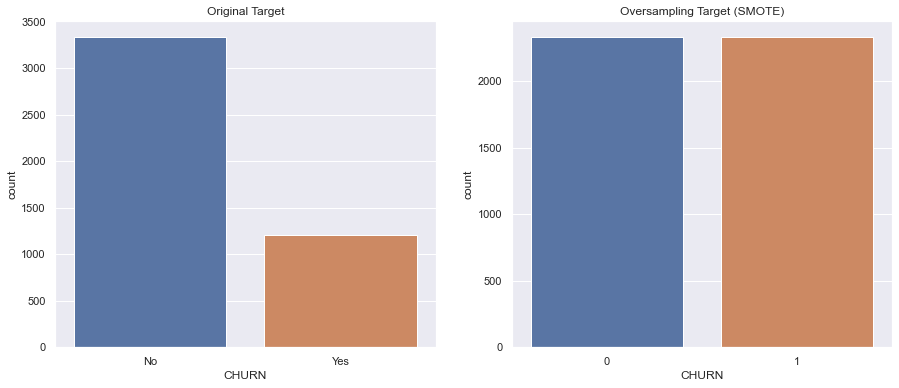

In [30]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.countplot(x=TARGET_NAME, data=data)
plt.title("Original Target")
plt.subplot(1,2,2)
sns.countplot(x=y_train_over)
plt.title("Oversampling Target (SMOTE)")
plt;

Obtemos um resultado melhor com __Oversampling__. 

In [22]:
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier


from timeit import default_timer as timer
from datetime import timedelta, datetime


# Start Measure time elapsed
start = timer()
print(f"Time Started: {datetime.now().strftime('%H:%M:%S')}\n")
# Code here ...

# params = study.best_trial.params

mdl = CatBoostClassifier(**params,
                         random_state=SEED,                          
                         verbose=0)

mdl.fit(X_train_over[feat_import], y_train_over)

preds = mdl.predict(X_valid[feat_import])

print(f"F1 Scores: {f1_score(y_valid, preds):0.6f}")


# End Measure time elapsed
end = timer()
print(f'\nTime Elapsed: {timedelta(seconds = end - start)}')

Time Started: 13:09:34

F1 Scores: 0.618926

Time Elapsed: 0:00:02.196531


# Save Model

Salvando o modelo treinado com a biblioteca __“joblib”__.

In [41]:
import joblib as jb
from datetime import datetime

day = datetime.now().day
month = datetime.now().month
year = datetime.now().year

name_mdl = "catboots"

path_mdl = f"models/{name_mdl}_{day}_{month}_{year}.pkl.z"

jb.dump(mdl, Path+path_mdl)

['models/catboots_15_9_2022.pkl.z']

# Conclusão


Como podemos ver, nosso melhor modelo o __CatBoostClassifier__ rodando com o pré-processamento e os parâmetros default conseguimos um __F1 Score__ de 0.561129. Utilizando algumas técnicas de ML como __Hyperparameter Tuning, Feature Importance e Imbalance Data__ atingimos o valor de 0.618926. Uma melhora de 10,3%.

O objetivo deste artigo era demonstrar o processo de trabalho de __Machine Learning__ usando algumas técnicas do dia a dia de um Cientista de Dados em nível iniciante. 

Quem puder encontrar inconsistências e formas de melhorar esse artigo, basta entrar em contato.

In [1]:
score = 0.561129
score_tune =  0.618926

(score_tune  / score) - 1

0.10300127065255937